In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
#!pip install timm

In [6]:
import timm
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
import numpy as np
import random
import math
import time
import os
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import cv2


# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)

In [7]:
def imshow(img, title=None):
    """Show an image with matplotlib."""
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def show_batch(dataloader, class_names):
    """Show a batch of images from the dataloader."""
    # Get a batch of images
    inputs, labels = next(iter(dataloader))

    # Make a grid from the batch
    grid = torchvision.utils.make_grid(inputs)

    # Show the images
    imshow(grid, title=[class_names[x] for x in labels])


In [8]:
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=15),  # Rotate by up to 15 degrees
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}

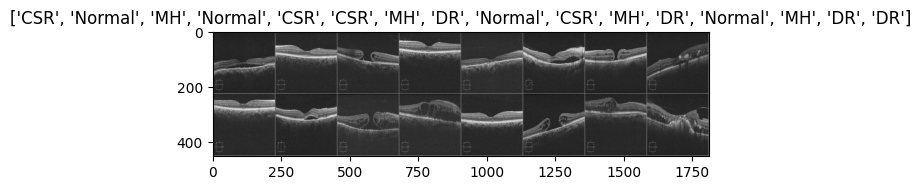

In [9]:
# Load the dataset
data_dir = '/kaggle/input/dataset/Dataset'
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])
class_names = full_dataset.classes

# Function to split dataset by class sequentially
def split_dataset_by_class_sequential(dataset, test_ratio=0.2, val_ratio=0.1):
    train_indices = []
    val_indices = []
    test_indices = []
    targets = dataset.targets

    for class_index in range(len(dataset.classes)):
        class_indices = [i for i, target in enumerate(targets) if target == class_index]
        class_size = len(class_indices)
        class_test_size = int(math.ceil(class_size * test_ratio))
        class_val_size = int(math.ceil((class_size - class_test_size) * val_ratio))

        class_test_indices = class_indices[:class_test_size]
        class_val_indices = class_indices[class_test_size:class_test_size + class_val_size]
        class_train_indices = class_indices[class_test_size + class_val_size:]

        test_indices.extend(class_test_indices)
        val_indices.extend(class_val_indices)
        train_indices.extend(class_train_indices)

    return train_indices, val_indices, test_indices

# Split the dataset
train_indices, val_indices, test_indices = split_dataset_by_class_sequential(full_dataset)

# Create train, validation, and test datasets
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

# Update transforms for validation and test sets
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create data loaders
batch_size = 16
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Display sample images from the training set
show_batch(dataloaders['train'], class_names)

In [10]:
# Fine-tune function for training the models
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [11]:
# Training parameters
num_epochs = 10

# EfficientNet
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
num_ftrs = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
efficientnet_model = efficientnet_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
efficientnet_model = train_model(efficientnet_model, criterion, optimizer, scheduler, num_epochs=num_epochs)

# Inception
inception_model = timm.create_model('inception_v4', pretrained=True)
#inception_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
num_ftrs = inception_model.last_linear.in_features
inception_model.last_linear = nn.Linear(num_ftrs, len(class_names))
inception_model = inception_model.to(device)
optimizer = optim.Adam(inception_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
inception_model = train_model(inception_model, criterion, optimizer, scheduler, num_epochs=num_epochs)

# DenseNet
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_ftrs, len(class_names))
densenet_model = densenet_model.to(device)
optimizer = optim.Adam(densenet_model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
densenet_model = train_model(densenet_model, criterion, optimizer, scheduler, num_epochs=num_epochs)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


Epoch 0/9
----------
train Loss: 0.7143 Acc: 0.7340
val Loss: 1.7185 Acc: 0.5510

Epoch 1/9
----------
train Loss: 0.3393 Acc: 0.8990
val Loss: 1.1061 Acc: 0.6122

Epoch 2/9
----------
train Loss: 0.2787 Acc: 0.9064
val Loss: 0.3965 Acc: 0.8367

Epoch 3/9
----------
train Loss: 0.2749 Acc: 0.9236
val Loss: 0.6602 Acc: 0.7551

Epoch 4/9
----------
train Loss: 0.2186 Acc: 0.9360
val Loss: 1.5682 Acc: 0.6122

Epoch 5/9
----------
train Loss: 0.1575 Acc: 0.9483
val Loss: 0.4374 Acc: 0.8367

Epoch 6/9
----------
train Loss: 0.0750 Acc: 0.9803
val Loss: 0.4163 Acc: 0.8571

Epoch 7/9
----------
train Loss: 0.0300 Acc: 0.9901
val Loss: 0.3999 Acc: 0.8980

Epoch 8/9
----------
train Loss: 0.0297 Acc: 0.9901
val Loss: 0.4494 Acc: 0.8776

Epoch 9/9
----------
train Loss: 0.0271 Acc: 0.9901
val Loss: 0.4711 Acc: 0.8571

Training complete in 0m 28s
Best val Acc: 0.8980


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Epoch 0/9
----------
train Loss: 0.9123 Acc: 0.6478
val Loss: 60.7237 Acc: 0.2245

Epoch 1/9
----------
train Loss: 0.8019 Acc: 0.7512
val Loss: 1.6719 Acc: 0.5918

Epoch 2/9
----------
train Loss: 0.4790 Acc: 0.8448
val Loss: 2.3809 Acc: 0.4490

Epoch 3/9
----------
train Loss: 0.3838 Acc: 0.8842
val Loss: 0.8287 Acc: 0.7755

Epoch 4/9
----------
train Loss: 0.3756 Acc: 0.8916
val Loss: 0.3277 Acc: 0.9184

Epoch 5/9
----------
train Loss: 0.3481 Acc: 0.8916
val Loss: 0.5019 Acc: 0.7755

Epoch 6/9
----------
train Loss: 0.3086 Acc: 0.9261
val Loss: 0.4746 Acc: 0.8776

Epoch 7/9
----------
train Loss: 0.3139 Acc: 0.9286
val Loss: 0.5154 Acc: 0.8776

Epoch 8/9
----------
train Loss: 0.1040 Acc: 0.9877
val Loss: 0.4531 Acc: 0.8571

Epoch 9/9
----------
train Loss: 0.1180 Acc: 0.9754
val Loss: 0.4123 Acc: 0.9184

Training complete in 1m 10s
Best val Acc: 0.9184


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 124MB/s] 


Epoch 0/9
----------
train Loss: 0.6835 Acc: 0.7512
val Loss: 3.3015 Acc: 0.5510

Epoch 1/9
----------
train Loss: 0.4347 Acc: 0.8621
val Loss: 1.7993 Acc: 0.6327

Epoch 2/9
----------
train Loss: 0.2410 Acc: 0.9310
val Loss: 0.8826 Acc: 0.6327

Epoch 3/9
----------
train Loss: 0.2341 Acc: 0.9310
val Loss: 0.4548 Acc: 0.8980

Epoch 4/9
----------
train Loss: 0.3003 Acc: 0.9015
val Loss: 0.9470 Acc: 0.7755

Epoch 5/9
----------
train Loss: 0.2358 Acc: 0.9236
val Loss: 22.3758 Acc: 0.3469

Epoch 6/9
----------
train Loss: 0.3694 Acc: 0.8793
val Loss: 0.3719 Acc: 0.9184

Epoch 7/9
----------
train Loss: 0.1263 Acc: 0.9655
val Loss: 0.2349 Acc: 0.9388

Epoch 8/9
----------
train Loss: 0.0814 Acc: 0.9877
val Loss: 0.3180 Acc: 0.9388

Epoch 9/9
----------
train Loss: 0.0482 Acc: 0.9926
val Loss: 0.2835 Acc: 0.9184

Training complete in 0m 39s
Best val Acc: 0.9388


In [12]:
def get_model_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# Get predictions for validation and test sets
efficientnet_val_preds, val_labels = get_model_predictions(efficientnet_model, dataloaders['val'])
inception_val_preds, _ = get_model_predictions(inception_model, dataloaders['val'])
densenet_val_preds, _ = get_model_predictions(densenet_model, dataloaders['val'])

efficientnet_test_preds, test_labels = get_model_predictions(efficientnet_model, dataloaders['test'])
inception_test_preds, _ = get_model_predictions(inception_model, dataloaders['test'])
densenet_test_preds, _ = get_model_predictions(densenet_model, dataloaders['test'])


Test Accuracy: 0.9573
Confusion Matrix:
[[10  0  0  0  1]
 [ 1 20  0  0  0]
 [ 0  0 21  1  0]
 [ 0  0  1 20  0]
 [ 0  1  0  0 41]]


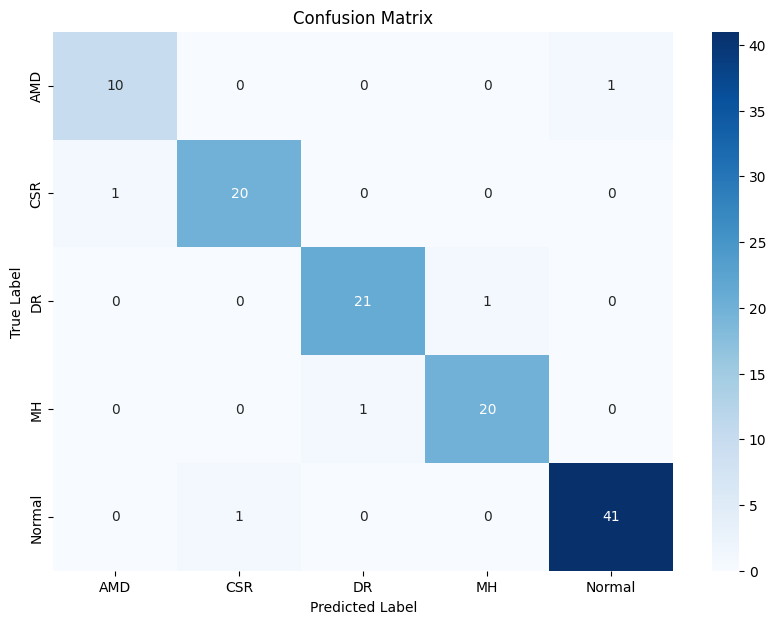

In [13]:
# Stack the base model predictions as features
val_features = np.hstack((efficientnet_val_preds, inception_val_preds, densenet_val_preds))
test_features = np.hstack((efficientnet_test_preds, inception_test_preds, densenet_test_preds))

# Train logistic regression as the meta-model
meta_model = LogisticRegression(max_iter=1000)
meta_model.fit(val_features, val_labels)

# Evaluate the meta-model on the test set
test_preds = meta_model.predict(test_features)
test_acc = accuracy_score(test_labels, test_preds)
print(f'Test Accuracy: {test_acc:.4f}')

# Compute the confusion matrix
cm = confusion_matrix(test_labels, test_preds)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


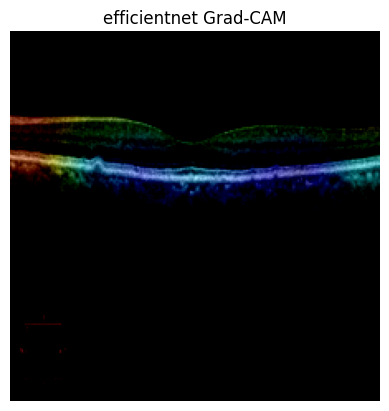

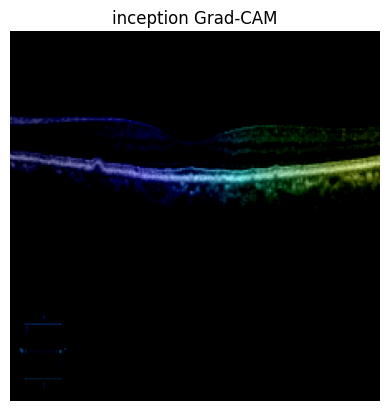

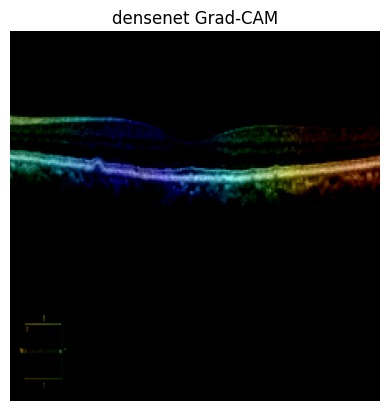

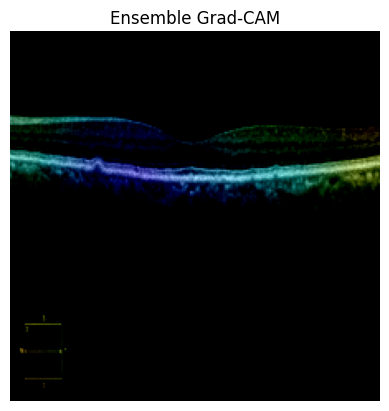

In [14]:
def register_hooks(model, target_layer_name):
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0]

    for name, module in model.named_modules():
        if name == target_layer_name:
            module.register_forward_hook(forward_hook)
            module.register_backward_hook(backward_hook)
    
    return activations, gradients

def generate_gradcam(model, input_tensor, class_idx, activations, gradients):
    model.eval()
    output = model(input_tensor)

    score = output[0, class_idx]
    model.zero_grad()
    score.backward()

    grads = gradients.get('value')
    acts = activations.get('value')

    if grads is None or acts is None:
        raise ValueError("Gradients or activations not found in the hook output.")

    pooled_grads = torch.mean(grads, dim=[0, 2, 3])

    for i in range(acts.shape[1]):
        acts[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(acts, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    return heatmap

def resize_heatmap(heatmap, size):
    return cv2.resize(heatmap, size)

target_layers = {
    'efficientnet': 'features.8.2',   
    'inception': 'features.21.branch3',          
    'densenet': 'features.norm5'      
}

def visualize_gradcam(input_image, heatmap, title='Grad-CAM'):
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    input_image = input_image.numpy().transpose(1, 2, 0)
    superimposed_img = np.clip(heatmap * 0.4 + input_image * 255, 0, 255)
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.title(title)
    plt.axis('off')
    plt.show()

def generate_ensemble_gradcam(models, dataloader, class_names, target_layers):
    input_tensor, label = next(iter(dataloader))
    input_tensor = input_tensor[0].unsqueeze(0).to(device)
    label = label[0].item()

    individual_heatmaps = []
    for model_name, model in models.items():
        activations, gradients = register_hooks(model, target_layers[model_name])
        output = model(input_tensor)
        class_idx = torch.argmax(output, dim=1).item()
        heatmap = generate_gradcam(model, input_tensor, class_idx, activations, gradients)
        individual_heatmaps.append(heatmap)
        visualize_gradcam(input_tensor.squeeze().cpu(), heatmap, title=f'{model_name} Grad-CAM')

    if individual_heatmaps:
        height, width = individual_heatmaps[0].shape
        resized_heatmaps = [resize_heatmap(heatmap, (width, height)) for heatmap in individual_heatmaps]
        ensemble_heatmap = np.mean(np.array(resized_heatmaps), axis=0)
        visualize_gradcam(input_tensor.squeeze().cpu(), ensemble_heatmap, title='Ensemble Grad-CAM')
    else:
        print("No heatmaps to process.")

# Example usage
models_dict = {
    'efficientnet': efficientnet_model,
    'inception': inception_model,
    'densenet': densenet_model
}

generate_ensemble_gradcam(models_dict, dataloaders['val'], class_names, target_layers)
